# ANALYSIS OF INTERNET ACCESS IN SÃO PAULO METROPOLITAN REGION OVER 2007-2020


# 1.SCRAPING GOVERN WEBSITE WITH SELENIUM

In [1]:
#Import webdriver and keys from selenium
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

In [2]:
#open a new Firefox browser. 
#don't forget to specify the path of the executable path as below
browser = webdriver.Firefox(executable_path=r'C://Webdriver/bin/geckodriver.exe')

#load the url homepage and stop the jupyter for 10s in order to complete the loading of the page
browser.get('https://dados.gov.br/dataset')
import time
time.sleep(10)

In [3]:
# Find the search box 
element = browser.find_element_by_xpath("//*[@id='dataset-search-form']/div[1]")
element.click()

#verify that "dados" is the title of the homepage
assert 'dados' in browser.title

#prepare the search box to find a specific word. 
elem = browser.find_element_by_name("q")

#clear the search box 
elem.clear()
#write the keyword to find and ask the search box to return the elements with the keyword
elem.send_keys("Multimídia")
elem.send_keys(Keys.RETURN)

In [4]:
#select the format of the element of interest. here the element selected is "Acesso de Comunicacao Multimídia" in csv format
element = browser.find_element_by_xpath("//*[@id='content']/div[3]/div/section[1]/div/ul/li[1]/ul/li[1]/a")
element.click()

In [5]:
#select explore option
element1 = browser.find_element_by_xpath("//*[@id='dataset-resources']/ul/li[1]/div")
element1.click()

In [6]:
#select "ir para recursos" to download the zip file
element2 = browser.find_element_by_xpath("//*[@id='dataset-resources']/ul/li[1]/div/ul/li[2]/a")
element2.click()

# 2. EXPLORATORY DATA ANALYSIS

In [156]:
#Import libraries to manipulate the data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
from scipy.stats import ttest_ind
import scipy.stats as stats
from scipy.stats import f_oneway
from sklearn.preprocessing import LabelEncoder

# 2.1. Import data 

In [157]:
acesso_2016 = pd.read_csv("Acessos_Banda_Larga_Fixa_2015-2016.csv", sep = ';', error_bad_lines = False)
acesso_2018 = pd.read_csv("Acessos_Banda_Larga_Fixa_2017-2018.csv", sep = ';', error_bad_lines = False)
acesso_2020 = pd.read_csv("Acessos_Banda_Larga_Fixa_2019-2020.csv", sep = ';', error_bad_lines = False)


# 2.2. Drop small companies and states other than São Paulo

In [4]:
acesso_2020.columns

Index(['Ano', 'Mês', 'Grupo Econômico', 'Empresa', 'CNPJ',
       'Porte da Prestadora', 'UF', 'Município', 'Código IBGE Município',
       'Faixa de Velocidade', 'Tecnologia', 'Meio de Acesso', 'Acessos'],
      dtype='object')

In [5]:
acesso_2020['Porte da Prestadora'].unique()

array(['Pequeno Porte', 'Grande Porte'], dtype=object)

In [158]:
def porte(dataframe, column1, column2):
    porte = dataframe.copy()
    porte = porte.drop(porte[(porte['Porte da Prestadora'] != column1) | (porte['UF'] != column2)].index)
    return porte

In [159]:
acesso_2016_sp = porte(acesso_2016, 'Grande Porte', 'SP')
acesso_2018_sp = porte(acesso_2018, 'Grande Porte', 'SP')
acesso_2020_sp = porte(acesso_2020, 'Grande Porte', 'SP')

# 2.3. Dataframe manipulation

In [160]:
acesso = [acesso_2016_sp, acesso_2018_sp, acesso_2020_sp]
acesso_sp = pd.concat(acesso)

In [9]:
acesso_sp.columns

Index(['Ano', 'Mês', 'Grupo Econômico', 'Empresa', 'CNPJ',
       'Porte da Prestadora', 'UF', 'Município', 'Código IBGE Município',
       'Faixa de Velocidade', 'Tecnologia', 'Meio de Acesso', 'Acessos'],
      dtype='object')

In [161]:
#Dropping the unnecessary columns
drop_acesso = acesso_sp.drop(columns=['Grupo Econômico', 'CNPJ', 'UF', 'Porte da Prestadora', 'Código IBGE Município', 'Meio de Acesso'])

In [11]:
drop_acesso.shape

(672595, 7)

In [13]:
#Rows containing duplicate data
duplicate_rows = drop_acesso[drop_acesso.duplicated()]
print('Number of duplicate rows: ', len(duplicate_rows))

Number of duplicate rows:  3096


In [14]:
#drop duplicated columns
drop_acesso.drop_duplicates()

,Ano,Mês,Empresa,Município,Faixa de Velocidade,Tecnologia,Acessos
24967,2016,12,VIVO,Santo Anastácio,0Kbps a 512Kbps,ATM,13
26161,2016,12,VIVO,São Caetano do Sul,512kbps a 2Mbps,Fibra,13
26162,2016,12,VIVO,Pacaembu,512kbps a 2Mbps,xDSL,617
26163,2016,12,VIVO,Campinas,12Mbps a 34Mbps,xDSL,19407
26164,2016,12,VIVO,Estiva Gerbi,512kbps a 2Mbps,ATM,4
...,...,...,...,...,...,...,...
3606829,2019,1,OI,Osasco,0Kbps a 512Kbps,FR,4
3606835,2019,1,OI,Barueri,0Kbps a 512Kbps,FR,6
3606840,2019,1,OI,Cotia,0Kbps a 512Kbps,FR,1
3606842,2019,1,OI,Guarulhos,512kbps a 2Mbps,FR,1


In [15]:
#sort by Ano and Mês
drop_acesso = drop_acesso.sort_values(by=['Ano', 'Mês'])

In [16]:
drop_acesso

,Ano,Mês,Empresa,Município,Faixa de Velocidade,Tecnologia,Acessos
2371895,2015,1,VIVO,São Paulo,2Mbps a 12Mbps,ETHERNET,4
2371923,2015,1,OI,São João da Boa Vista,512kbps a 2Mbps,xDSL,1
2372137,2015,1,VIVO,São Paulo,> 34Mbps,Fibra,152
2372212,2015,1,CLARO,Osasco,0Kbps a 512Kbps,Fibra,1
2374073,2015,1,CLARO,Cotia,512kbps a 2Mbps,Fibra,1
...,...,...,...,...,...,...,...
146587,2020,12,SKY/AT&T,Guarujá,2Mbps a 12Mbps,LTE,362
146590,2020,12,SKY/AT&T,Ibiúna,12Mbps a 34Mbps,LTE,5
146608,2020,12,SKY/AT&T,Tietê,2Mbps a 12Mbps,LTE,26
146610,2020,12,SKY/AT&T,Santos,2Mbps a 12Mbps,LTE,406


# select only the 6 metropolitan regions of SP

In [17]:
drop_acesso = drop_acesso.drop(drop_acesso[(drop_acesso['Município'] != 'São Paulo') & (drop_acesso['Município'] != 'Campinas') & (drop_acesso['Município'] != 'São José dos Campos') & (drop_acesso['Município'] != 'Sorocaba') & (drop_acesso['Município'] != 'Santos') & (drop_acesso['Município'] != 'Ribeirão Preto')].index)

In [18]:
drop_acesso['Município'].unique()

array(['São Paulo', 'Santos', 'Campinas', 'São José dos Campos',
       'Ribeirão Preto', 'Sorocaba'], dtype=object)

In [19]:
#Find which company has the most acessos and identify the tecnologia linked
drop_acesso[drop_acesso['Acessos'] == drop_acesso['Acessos'].max()]

,Ano,Mês,Empresa,Município,Faixa de Velocidade,Tecnologia,Acessos
98485,2020,12,CLARO,São Paulo,> 34Mbps,HFC,1224902


In [20]:
#Find which company has the least acessos and identify the tecnologia linked
drop_acesso[drop_acesso['Acessos'] == drop_acesso['Acessos'].min()]

,Ano,Mês,Empresa,Município,Faixa de Velocidade,Tecnologia,Acessos
2374075,2015,1,CLARO,Santos,512kbps a 2Mbps,xDSL,1
2374080,2015,1,CLARO,Campinas,0Kbps a 512Kbps,xDSL,1
2374084,2015,1,CLARO,Santos,0Kbps a 512Kbps,Fibra,1
2374160,2015,1,CLARO,São José dos Campos,0Kbps a 512Kbps,xDSL,1
2374170,2015,1,CLARO,São José dos Campos,512kbps a 2Mbps,Fibra,1
...,...,...,...,...,...,...,...
94076,2020,12,CLARO,Santos,> 34Mbps,Wi-Fi,1
94500,2020,12,CLARO,Sorocaba,0Kbps a 512Kbps,Wi-Fi,1
97817,2020,12,CLARO,Campinas,2Mbps a 12Mbps,Wi-Fi,1
99830,2020,12,CLARO,São José dos Campos,2Mbps a 12Mbps,xDSL,1


In [21]:
drop_acesso['Faixa de Velocidade'].unique()

array(['2Mbps a 12Mbps', '> 34Mbps', '512kbps a 2Mbps', '0Kbps a 512Kbps',
       '12Mbps a 34Mbps'], dtype=object)

In [116]:
drop_acesso

,Ano,Mês,Empresa,Município,Tecnologia,Acessos,Faixa de Velocidade Atualizada
1083,2010,12,VIVO,São Paulo,Outra,78,> 34Mbps
1115,2010,12,VIVO,Santos,Outra,35,> 34Mbps
2672,2010,12,VIVO,Santos,Híbrido,1361,0Kbps a 512Kbps
2685,2010,12,VIVO,São Paulo,Híbrido,184,> 34Mbps
2694,2010,12,VIVO,Sorocaba,Híbrido,421,512kbps a 2Mbps
...,...,...,...,...,...,...,...
3606707,2019,1,CLARO,São Paulo,xDSL,2,0Kbps a 512Kbps
3606709,2019,1,CLARO,Santos,xDSL,1,512kbps a 2Mbps
3606727,2019,1,CLARO,São Paulo,Fibra,357,0Kbps a 512Kbps
3606732,2019,1,CLARO,São Paulo,Fibra,957,512kbps a 2Mbps


# 2.4. Discrete Variable Analysis

Let's start first the discrete column "Acessos". The columns "Ano" and "Month" will not be investigated.

In [22]:
#define a function that will find outliers for any integer column and return a array.

def findoutliers(column):
    outliers = []
    Q1 = column.quantile(.25)
    Q3 = column.quantile(.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - (1.5 * IQR)
    upper_limit = Q3 + (1.5 * IQR)
    for out1 in column:
        if out1 > upper_limit or out1 < lower_limit:
            outliers.append(out1)
    return np.array(outliers)


In [23]:
#Data visualization
#define a function to display the distribution of the data and quantitative parameters (mean, count of outliers, Missing values, etc.)


def plotchart(column):
    fig, ax1 = plt.subplots(1,1,figsize=(12,8))
    ax1 = sns.boxplot(x = column)
    plt.title('Distribution of internet access over 2015-2020')
    print('Count of outliers ', len(findoutliers(column)))
    print('Quantitative data ', format(column.describe()))
    print('Missing values ', format(column.isnull().sum()))
    print('% of Missing values ', format(round(100*(column.isnull().sum()/len(column)),2)))


Count of outliers  5021
Quantitative data  count    2.728500e+04
mean     1.006305e+04
std      6.140667e+04
min      1.000000e+00
25%      5.000000e+00
50%      4.500000e+01
75%      4.640000e+02
max      1.224902e+06
Name: Acessos, dtype: float64
Missing values  0
% of Missing values  0.0


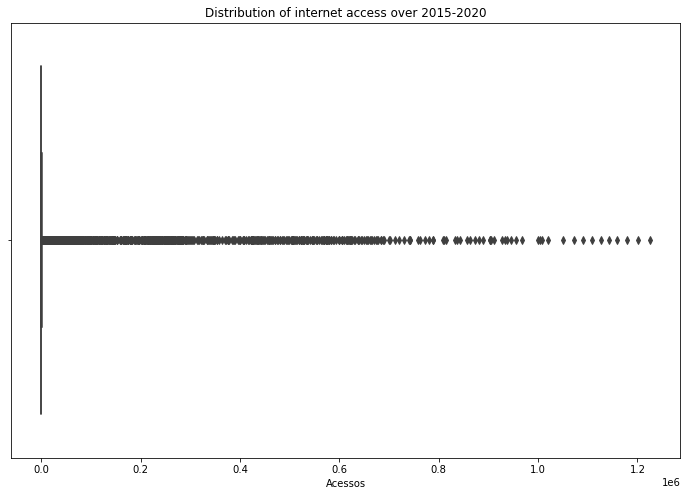

In [24]:
boxplot_Acessos = plotchart(drop_acesso['Acessos'])
boxplot_Acessos

# 2.5. Categorical Variables

# 2.5.1. Univariate analysis

First let's start with an univariate analysis of each categorical analysis

Below I define the following function:

1. catvarial - prints the frequency of the categorical column and the histogram of the categorial column

In [25]:
#define a function to analyze the categorical column

#catvarial function prints the frequency of the categorical column
def catvarial(column):
    print('Quantitative data ')
    print(format(column.value_counts()))
    fig, ax = plt.subplots(1,1,figsize=(12,8))
    ax = sns.histplot(x = column)
    
    

Quantitative data 
CLARO       10876
OI           8139
VIVO         5566
TIM          2393
SKY/AT&T      311
Name: Empresa, dtype: int64


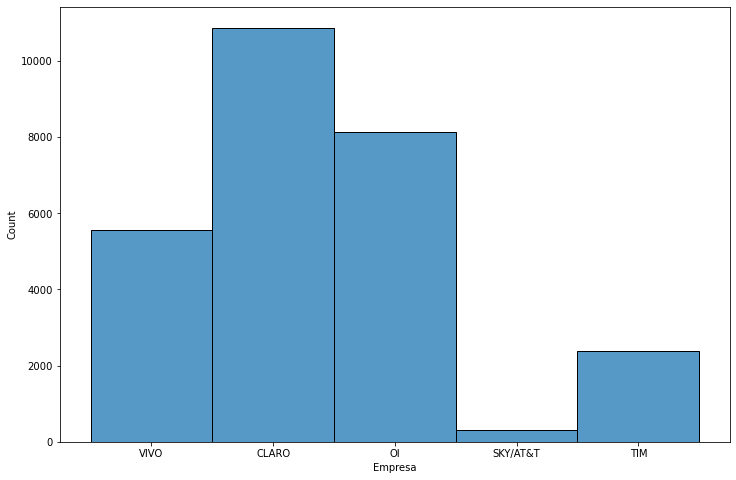

In [26]:
cat_empr = catvarial(drop_acesso['Empresa'])

Quantitative data 
São Paulo              8445
Campinas               4598
Ribeirão Preto         3725
Santos                 3658
São José dos Campos    3604
Sorocaba               3255
Name: Município, dtype: int64


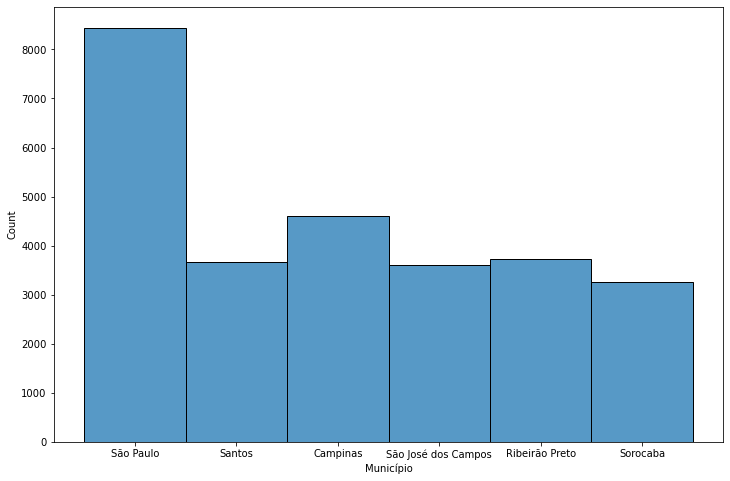

In [27]:
cat_muni = catvarial(drop_acesso['Município'])

Quantitative data 
512kbps a 2Mbps    7442
0Kbps a 512Kbps    6314
2Mbps a 12Mbps     4945
12Mbps a 34Mbps    4336
> 34Mbps           4248
Name: Faixa de Velocidade, dtype: int64


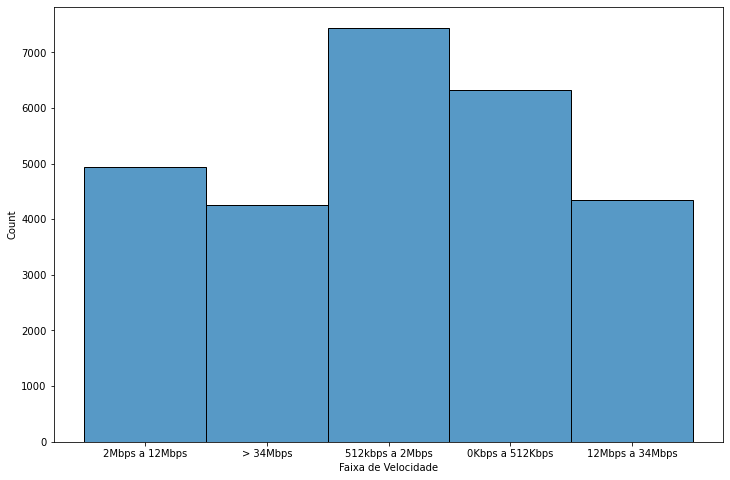

In [28]:
#call catvarial on Internet speed
cat_faixa_velocidade = catvarial(drop_acesso['Faixa de Velocidade'])

Quantitative data 
Fibra          7337
xDSL           5081
FWA            2752
HFC            2502
ETHERNET       2352
ATM            2238
VSAT           1661
Cable Modem    1284
FR              687
Wi-Fi           670
WIMAX           359
LTE             311
PLC              51
Name: Tecnologia, dtype: int64


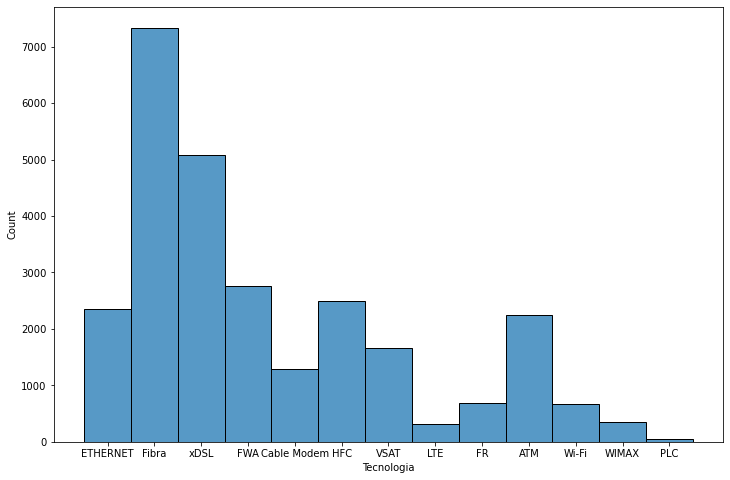

In [29]:
#call catvarial on internet technology
cat_tech = catvarial(drop_acesso['Tecnologia'])

# 2.5.2. Multivariate analysis

Let's establish the following relationship among all variables:

First let's start with "Acesso" column

1. Number of access and Brazilian states. 
2. Number of access and Internet speed range
3. Number of access and Technology

In [30]:
#define a function to display internet acess against other parameters
def multivarial(column):
    Access_multi = drop_acesso['Acessos'].groupby(column).sum().sort_values(ascending = True)
    f, ax = plt.subplots(1, 1, figsize=(15, 8))
    ax = sns.barplot(x = Access_multi.index, y = Access_multi)
    plt.title('Distribution of internet access over 2015-2020')

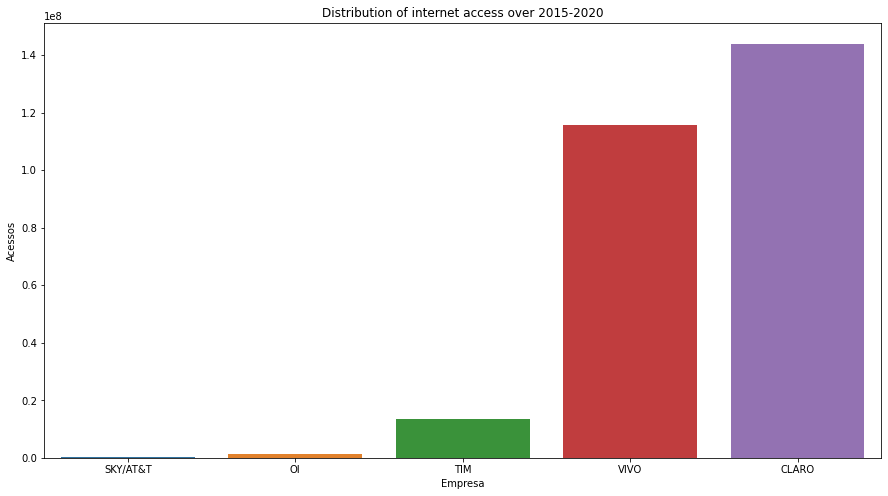

In [31]:
Access_per_empresa = multivarial(drop_acesso['Empresa'])

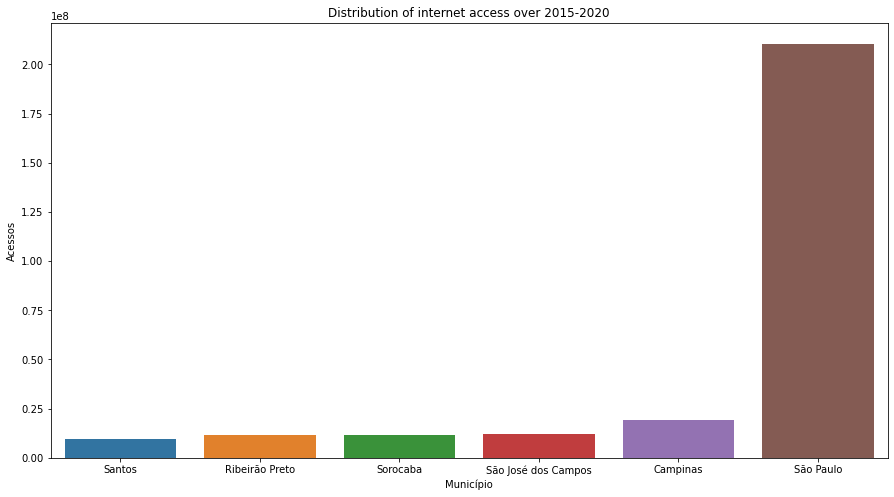

In [32]:
Access_per_municipio = multivarial(drop_acesso['Município'])

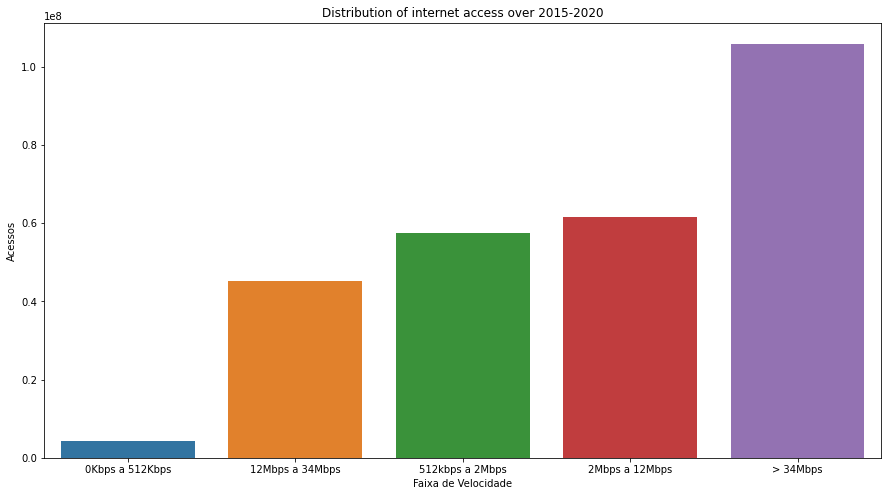

In [33]:
Access_per_faixa = multivarial(drop_acesso['Faixa de Velocidade'])

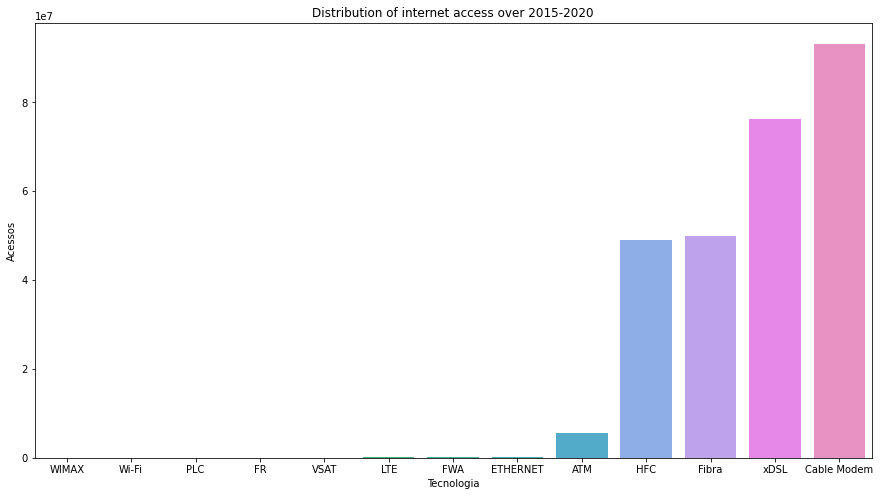

In [34]:
Access_per_tech = multivarial(drop_acesso['Tecnologia'])

Now let's perform the multivariate analysis on the categorical columns only. 

In [35]:
def multicat(colum1, colum2):
    f, ax = plt.subplots(1, 1, figsize=(15, 8))
    ax = sns.countplot(x = colum1 , hue = colum2, data = drop_acesso)

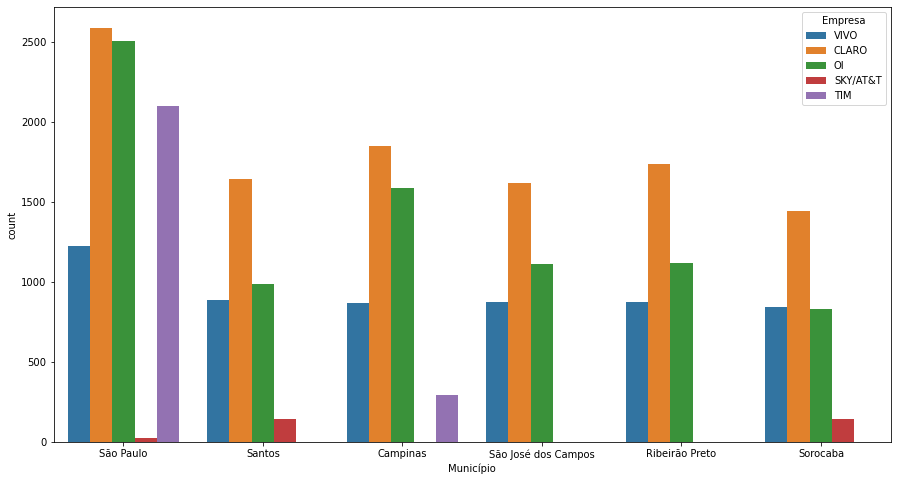

In [36]:
muni_empr = multicat('Município', 'Empresa')

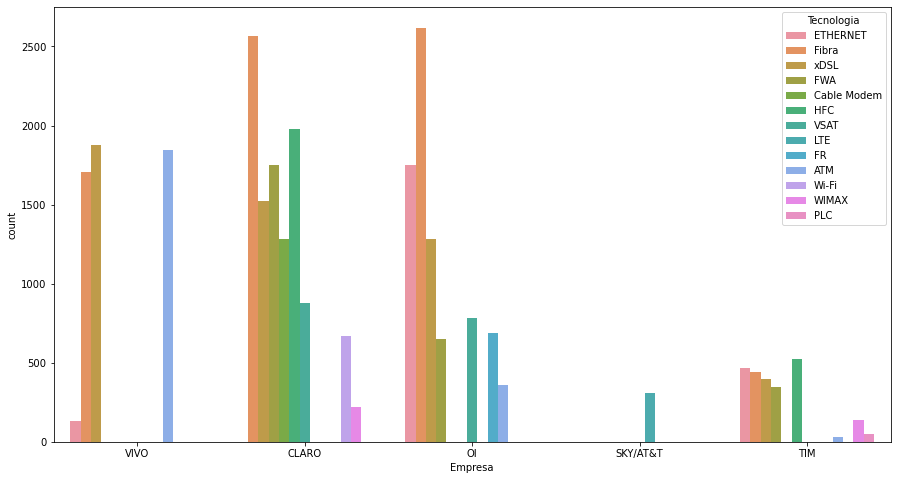

In [37]:
empr_tech = multicat('Empresa', 'Tecnologia')

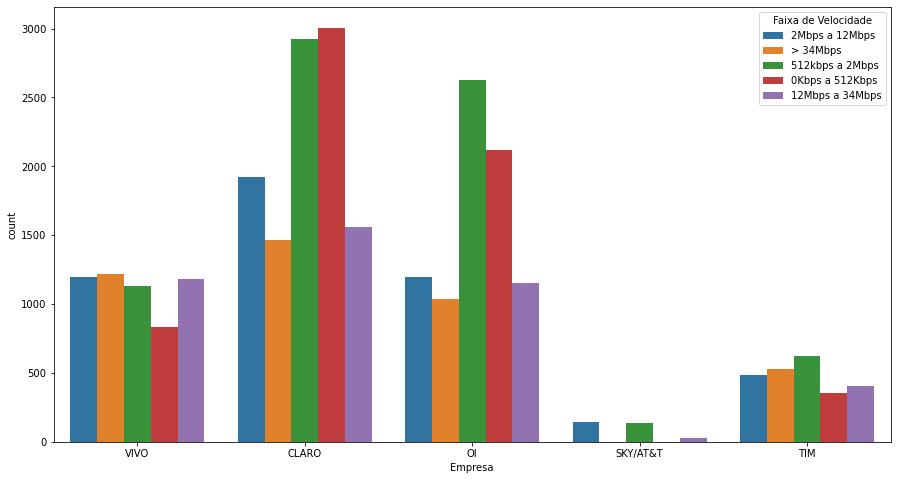

In [38]:
empr_faixa = multicat('Empresa', 'Faixa de Velocidade')

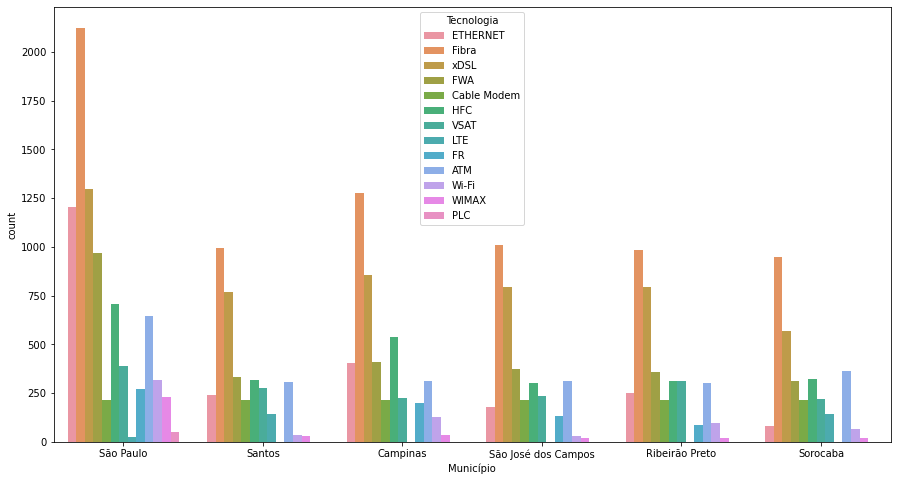

In [39]:
muni_techn = multicat('Município', 'Tecnologia')

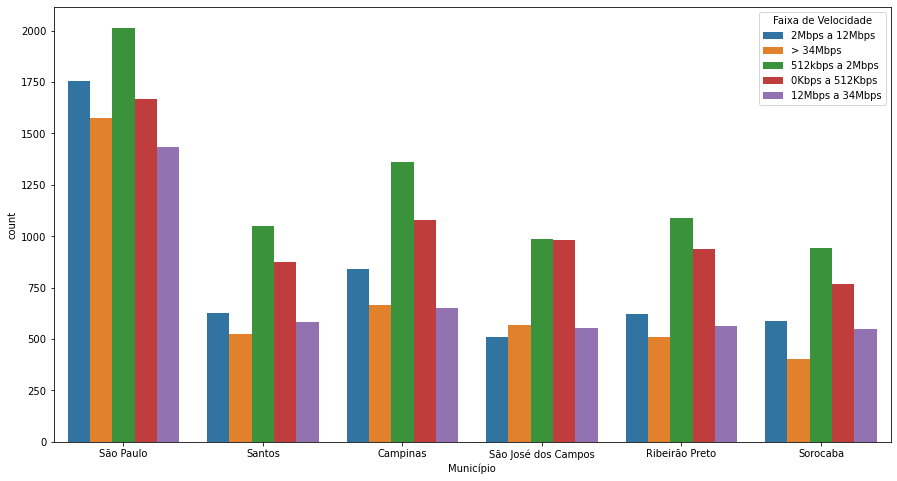

In [40]:
muni_faixa = multicat('Município', 'Faixa de Velocidade')

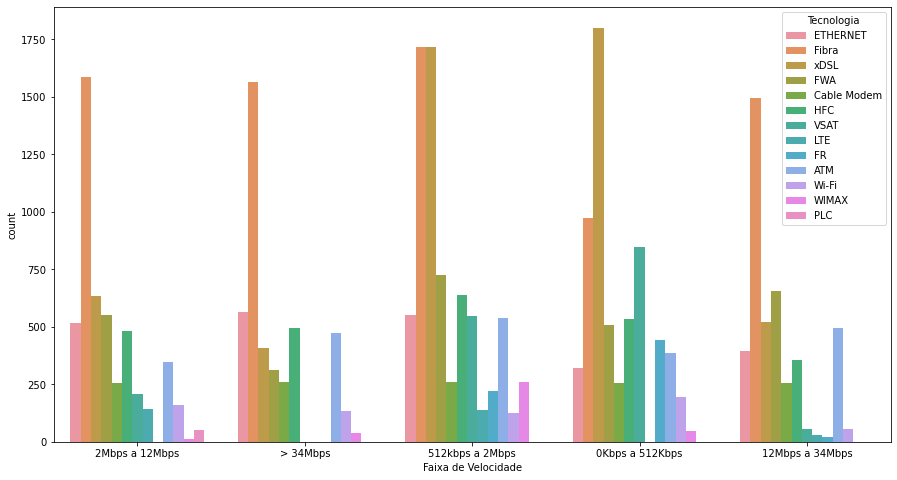

In [41]:
faixa_tecnh = multicat('Faixa de Velocidade', 'Tecnologia')

# 3. Hypothesis Testing

2 Sample T-test 

Does the access to Internet changes from one city to another ?

H0: The access to internet in São Paulo and in Ribeirão Preto is the same

H1: The access to internet in São Paulo and in Ribeirão Preto is not the same

In [42]:
x = np.array(drop_acesso[drop_acesso.Município == 'São Paulo'].Acessos) 
y = np.array(drop_acesso[drop_acesso.Município == 'Ribeirão Preto'].Acessos)
t, p_value  = stats.ttest_ind(x,y, axis = 0) 
if p_value < 0.05:  # Setting our significance level at 5%
    print('Rejecting Null Hypothesis. That means the access to internet in São Paulo and in Ribeirão Preto is not the same')
else:
    print('Fail to Reject Null Hypothesis. That means the access to internet in São Paulo and in Ribeirão Preto is the same')

Rejecting Null Hypothesis. That means the access to internet in São Paulo and in Ribeirão Preto is not the same


2 Sample T-test 

Does the access to Internet changes from one internet provider to another ?

H0: The access to internet with CLARO and OI is the same

H1: The access to internet with CLARO and OI is not the same

In [43]:
x = np.array(drop_acesso[drop_acesso.Empresa == 'CLARO'].Acessos) 
y = np.array(drop_acesso[drop_acesso.Empresa == 'OI'].Acessos)
t, p_value_2  = stats.ttest_ind(x,y, axis = 0) 
if p_value_2 < 0.05:  # Setting our significance level at 5%
    print('Rejecting Null Hypothesis. That means that the access to internet with CLARO and OI is not the same')
else:
    print('Fail to Reject Null Hypothesis. That means the access to internet with CLARO and OI is the same')

Rejecting Null Hypothesis. That means that the access to internet with CLARO and OI is not the same


2 Sample T-test 

Does the access to Internet changes with the internet speed range ?

H0: The access to internet with a speed ranges of 2Mbps-34Mbps is the same with one of 512kbps-2Mbps

H1: The access to internet with a speed ranges of 2Mbps-34Mbps is not the same with one of 512kbps-2Mbps

In [44]:
x = np.array(drop_acesso[drop_acesso['Faixa de Velocidade'] == '2Mbps a 12Mbps'].Acessos) 
y = np.array(drop_acesso[drop_acesso['Faixa de Velocidade'] == '512kpbs a 2Mbps'].Acessos)
t, p_value_3  = stats.ttest_ind(x,y, axis = 0) 
if p_value_3 < 0.05:  # Setting our significance level at 5%
    print('Rejecting Null Hypothesis.')
else:
    print('Fail to Reject Null Hypothesis')

Fail to Reject Null Hypothesis


2 Sample T-test 

Does the access to Internet changes with the internet technology ?

H0: The access to internet with a xDSL technology is the same with Optical Fiber , "Fibra"

H0: The access to internet with a xDSL technology is not the same with Optical Fiber , "Fibra"

In [45]:
x = np.array(drop_acesso[drop_acesso['Tecnologia'] == 'xDSL'].Acessos) 
y = np.array(drop_acesso[drop_acesso['Tecnologia'] == 'Fibra'].Acessos)
t, p_value_4  = stats.ttest_ind(x,y, axis = 0) 
if p_value_4 < 0.05:  # Setting our significance level at 5%
    print('Rejecting Null Hypothesis.')
else:
    print('Fail to Reject Null Hypothesis.')

Rejecting Null Hypothesis.


# 4. HEATMAP

In [48]:
drop_sort = drop_acesso.copy()
drop_sort

,Ano,Mês,Empresa,Município,Faixa de Velocidade,Tecnologia,Acessos
2371895,2015,1,VIVO,São Paulo,2Mbps a 12Mbps,ETHERNET,4
2372137,2015,1,VIVO,São Paulo,> 34Mbps,Fibra,152
2374075,2015,1,CLARO,Santos,512kbps a 2Mbps,xDSL,1
2374080,2015,1,CLARO,Campinas,0Kbps a 512Kbps,xDSL,1
2374082,2015,1,CLARO,São Paulo,2Mbps a 12Mbps,Fibra,7
...,...,...,...,...,...,...,...
146036,2020,12,SKY/AT&T,Sorocaba,12Mbps a 34Mbps,LTE,31
146215,2020,12,SKY/AT&T,Santos,512kbps a 2Mbps,LTE,154
146323,2020,12,SKY/AT&T,São Paulo,512kbps a 2Mbps,LTE,1
146501,2020,12,SKY/AT&T,Sorocaba,512kbps a 2Mbps,LTE,145


In [49]:
drop_sort[['Empresa', 'Município','Faixa de Velocidade', 'Tecnologia']] = drop_sort[['Empresa', 'Município','Faixa de Velocidade', 'Tecnologia']].astype('category')
drop_sort.dtypes

Ano                       int64
Mês                       int64
Empresa                category
Município              category
Faixa de Velocidade    category
Tecnologia             category
Acessos                   int64
dtype: object

In [51]:
label = LabelEncoder()
label.fit(drop_sort.Empresa)
drop_sort.Empresa = label.transform(drop_sort.Empresa)
label.fit(drop_sort['Município'])
drop_sort['Município'] = label.transform(drop_sort['Município'])
label.fit(drop_sort['Faixa de Velocidade'])
drop_sort['Faixa de Velocidade'] = label.transform(drop_sort['Faixa de Velocidade'])
label.fit(drop_sort['Tecnologia'])
drop_sort['Tecnologia'] = label.transform(drop_sort['Tecnologia'])
drop_sort.dtypes

Ano                    int64
Mês                    int64
Empresa                int64
Município              int64
Faixa de Velocidade    int32
Tecnologia             int32
Acessos                int64
dtype: object

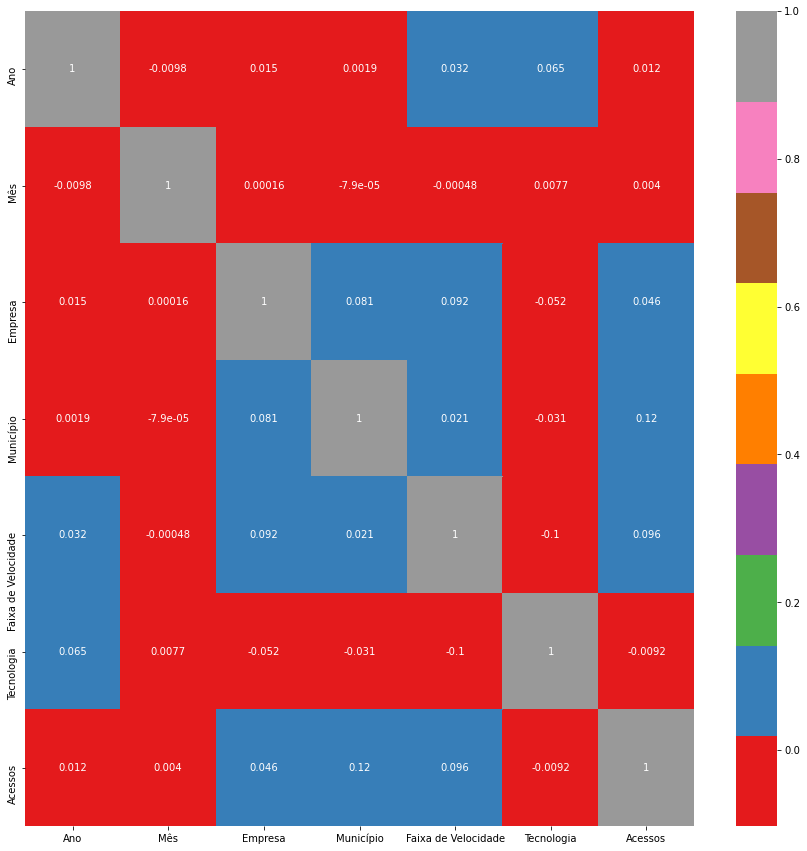

In [52]:
#Correlation matrix
f, ax = plt.subplots(1, 1, figsize=(15, 15))
ax = sns.heatmap(drop_sort.corr(), annot=True, cmap='Set1')

# Remove multicollinearity

In [53]:
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [54]:
#Remove multicollinearity
#create a list of feature names

independent_variables = ['Empresa', 'Município', 'Faixa de Velocidade', 'Tecnologia']
X = drop_sort[independent_variables]
y = drop_sort['Acessos']

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(1)


,VIF Factor,features
0,1.7,Empresa
1,2.5,Município
2,2.3,Faixa de Velocidade
3,2.2,Tecnologia


# MACHINE LEARNING MODELING - DECISION TREE

In [73]:
df=drop_acesso.copy()
df

,Ano,Mês,Empresa,Município,Faixa de Velocidade,Tecnologia,Acessos
2371895,2015,1,VIVO,São Paulo,2Mbps a 12Mbps,ETHERNET,4
2372137,2015,1,VIVO,São Paulo,> 34Mbps,Fibra,152
2374075,2015,1,CLARO,Santos,512kbps a 2Mbps,xDSL,1
2374080,2015,1,CLARO,Campinas,0Kbps a 512Kbps,xDSL,1
2374082,2015,1,CLARO,São Paulo,2Mbps a 12Mbps,Fibra,7
...,...,...,...,...,...,...,...
146036,2020,12,SKY/AT&T,Sorocaba,12Mbps a 34Mbps,LTE,31
146215,2020,12,SKY/AT&T,Santos,512kbps a 2Mbps,LTE,154
146323,2020,12,SKY/AT&T,São Paulo,512kbps a 2Mbps,LTE,1
146501,2020,12,SKY/AT&T,Sorocaba,512kbps a 2Mbps,LTE,145


In [81]:
df = df[(df['Tecnologia']=='Fibra') | (df['Tecnologia']=='Cable Modem') | (df['Tecnologia']=='HFC') | (df['Tecnologia']=='xDSL') ]
df = df.copy()

In [82]:
df.loc[df['Acessos'] < 5000, 'Survey'] = 0
df.loc[df['Acessos'] >= 5000, 'Survey'] = 1

In [83]:
df['Survey'] = df['Survey'].astype(int)
df

,Ano,Mês,Empresa,Município,Faixa de Velocidade,Tecnologia,Acessos,Survey
2372137,2015,1,VIVO,São Paulo,> 34Mbps,Fibra,152,0
2374075,2015,1,CLARO,Santos,512kbps a 2Mbps,xDSL,1,0
2374080,2015,1,CLARO,Campinas,0Kbps a 512Kbps,xDSL,1,0
2374082,2015,1,CLARO,São Paulo,2Mbps a 12Mbps,Fibra,7,0
2374084,2015,1,CLARO,Santos,0Kbps a 512Kbps,Fibra,1,0
...,...,...,...,...,...,...,...,...
99789,2020,12,CLARO,Sorocaba,0Kbps a 512Kbps,Fibra,20,0
99827,2020,12,CLARO,Santos,0Kbps a 512Kbps,Fibra,34,0
99830,2020,12,CLARO,São José dos Campos,2Mbps a 12Mbps,xDSL,1,0
100058,2020,12,CLARO,Ribeirão Preto,2Mbps a 12Mbps,HFC,10374,1


Modeling the decision tree classifier

In [85]:
inputs = df.drop(columns=['Acessos', 'Survey'])
target = df['Survey']

In [94]:
inputs[['Empresa', 'Município','Faixa de Velocidade', 'Tecnologia']] = inputs[['Empresa', 'Município','Faixa de Velocidade', 'Tecnologia']].astype('category')
inputs.dtypes

Ano                       int64
Mês                       int64
Empresa                category
Município              category
Faixa de Velocidade    category
Tecnologia             category
dtype: object

In [95]:
label = LabelEncoder()
label.fit(inputs.Empresa)
inputs.Empresa = label.transform(inputs.Empresa)
label.fit(inputs['Município'])
inputs['Município'] = label.transform(inputs['Município'])
label.fit(inputs['Faixa de Velocidade'])
inputs['Faixa de Velocidade'] = label.transform(inputs['Faixa de Velocidade'])
label.fit(inputs['Tecnologia'])
inputs['Tecnologia'] = label.transform(inputs['Tecnologia'])
inputs.dtypes

Ano                    int64
Mês                    int64
Empresa                int32
Município              int32
Faixa de Velocidade    int32
Tecnologia             int32
dtype: object

In [96]:
x_train = inputs.iloc[:-30]
x_test = inputs.iloc[-30:]
y_train = target.iloc[:-30]
y_test = target.iloc[-30:]

In [92]:
from sklearn import tree

In [98]:
model = tree.DecisionTreeClassifier()
model.fit(x_train, y_train)

DecisionTreeClassifier()

In [163]:
from sklearn.metrics import accuracy_score

In [164]:
y_pred = model.predict(x_test)

In [165]:
accuracy_score(y_test, y_pred)

0.8333333333333334